In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
from scipy.interpolate import interp1d as intp
import matplotlib.pyplot as plt
from astropy.io import fits
import source.selection_criteria as sc
import astropy.table as table
import astropy.units as u
import importlib
from sklearn.neighbors import KernelDensity

utils.configure_plot_params()

/Users/runburg/github/agn_lf


In [2]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
outfile = 'lf_xray'
label = 'Full XSERVS sample'
specz = 'ZSPEC'
photoz = 'ZPHOT'
truncate_radec=[34.2, 37.1, -5.73, -3.87]

specz_only = True
if specz_only is True:
    outfile = 'lf_xray_specz_only'
    label = 'Only specz'

xmatch = False
ir_select = False

if xmatch is True:
    xservs_catalog = table.Table.read('./data/ir_and_xray.fits')
    outfile = 'lf_xray_crossmatch_xray_selected'
    specz = 'zspec_1'
    # specz = 'redshift'
    # photoz = 'ZPHOT'
    photoz = 'z1_median'
    label = 'Crossmatch, X-ray selected'
    if ir_select is True:
        outfile = 'lf_xray_crossmatch_ir_selected'
        label = 'Crossmatch, IR selected'

    ra_up = 36.5
    ra_down = 34.25
    dec_up = -4.0
    dec_down = -5.5 
    catalog = xservs_catalog
    xservs_catalog = xservs_catalog[(ra_down < catalog['RA_2']) & (catalog['RA_2'] < ra_up)& (dec_down < catalog['DEC_2']) & (catalog['DEC_2'] < dec_up)]
    truncate_radec = [ra_down, ra_up, dec_down, dec_up]

    if ir_select is True:
        flux36 = 'f_ap_irac_i1'
        flux45 = 'f_ap_irac_i2'
        flux58 = 'f_ap_irac_i3'
        flux80 = 'f_ap_irac_i4'
        flux240 = 'f_mips_24'
        never_nan = (np.nan_to_num(xservs_catalog[flux58], nan=-99) > 0) & (np.nan_to_num(xservs_catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(xservs_catalog[specs], nan=-99) > 0)

        selected_agn = sc.select_ir(xservs_catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
        xservs_catalog = xservs_catalog[never_nan][selected_agn]
        
if specz_only is True:
    full_fluxes = xservs_catalog[(xservs_catalog[photoz] > 0 ) | (xservs_catalog[specz] > 0)]
    xservs_catalog = xservs_catalog[np.nan_to_num(xservs_catalog[specz], nan=-99) > 0]
else:
    xservs_catalog = xservs_catalog[(xservs_catalog[photoz] > 0 ) | (xservs_catalog[specz] > 0)]
    full_fluxes = xservs_catalog

In [3]:
selection_lum = 3e42

# xservs_catalog = 

cosmo = af.setup_cosmology()

print(len(xservs_catalog))

1767


In [4]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 2e43 #erg/s
l_sample_max = 3e46 #erg/s 

num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

flux_limit = 6.5e-15

image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
wcs, hdu = utils.load_wcs(image_file)

cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9, truncate_radec=truncate_radec)

# full_fluxes = xservs_catalog['FB_FLUX']
goodzs = (xservs_catalog[photoz] > 0) & (xservs_catalog[specz] > 0)
difs = xservs_catalog[photoz][goodzs] - xservs_catalog[specz][goodzs]

kds = []
for i in np.arange(len(z_bins)-1):
    inbin = (xservs_catalog[photoz][goodzs] > z_bins[i]) & (xservs_catalog[photoz][goodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xservs_catalog[specz][goodzs][inbin][:, None])
    
    kds.append(kde)
    
# spectral_index = 1.7
spectral_index = np.log10(xservs_catalog['HB_FLUX'].data/xservs_catalog['SB_FLUX'].data) / np.log10(6/1.25)
bolo_corr = 1
# bolo_corr = 12

with np.load('./data/incompleteness_corrections_mag.npz') as f:
    mags = f['mags']
    corrs = f['corrs']
    f_corr = f['fluxes']

corr_fn = intp(f_corr, corrs, bounds_error=False, fill_value=1) 

N = 1000

if specz_only is True:
    N = 1


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


/Users/runburg/github/agn_lf/source/vmax.py:217: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(data[:-1, :-1] * truncate_radec).flatten()


The total coverage is 5.392516341375583 square degrees.


In [5]:
# fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='X', unit=r'erg s$^{-1}$')

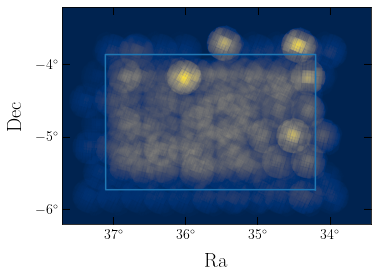

In [6]:
if xmatch is False:
    vmax.exposure_plot(wcs, hdu.data, outfile='./output/paper_plots/exposure_map.pdf', truncate_radec=truncate_radec)

Total coverage for: 5.38599400128031 square degrees.


(<Figure size 388.8x280.8 with 1 Axes>,
 <AxesSubplot:xlabel='Flux [photons/area/s]', ylabel='Coverage [deg$^2$]'>)

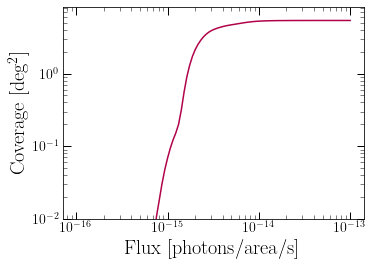

In [7]:
vmax.cov_func_plot(cov_function, -16, -13, outfile='./output/paper_plots/xservs_coverage.pdf')

In [8]:
import time
start_time = time.time()
lf_chain = np.zeros((N, num_bins_z-1, num_bins_l-1))
# lf_err_chain = lf_chain[:]

for i in range(N):
    if i % 50 == 0:
        print('progress', round(i/N * 100, 2), '%')
        

    randomz = np.zeros(len(xservs_catalog))
    ### use zphot - ZSPEC to estimate uncertainty on z
#     for j in np.arange(len(z_bins) - 1):
#         inbin = (xservs_catalog[photoz][goodzs] >= z_bins[j]) & (xservs_catalog[photoz][goodzs] < z_bins[j+1])
#         histo, bin_edges = np.histogram(difs[inbin], bins=200)

#         photoz_inbin = (xservs_catalog[photoz] >= z_bins[j]) & (xservs_catalog[photoz] < z_bins[j+1])
#         randomz[photoz_inbin] = xservs_catalog[photoz][photoz_inbin] - np.random.choice((bin_edges[:-1]), size=np.sum(photoz_inbin), p=histo/np.sum(histo))
        
#         while np.any(randomz < 0):
#             indices = randomz < 0
#             randomz[indices] = xservs_catalog[photoz][indices] - np.random.choice((bin_edges[:-1]), size=np.sum(indices), p=histo/np.sum(histo))

    for j, kd in enumerate(kds):
        photoz_inbin = (xservs_catalog[photoz] >= z_bins[j]) & (xservs_catalog[photoz] < z_bins[j+1])
        randomz[photoz_inbin] = kd.sample(np.sum(photoz_inbin)).flatten()
        
    xservs_catalog['random_z'] = randomz
    z = np.array([row[specz] if row[specz] > 0 else row['random_z'] for row in xservs_catalog])  
#     z = np.array([row[specz] if row[specz] > 0 else np.random.normal(row[photoz], (row['ZPHOT_UERR'] - row['ZPHOT_LERR'])/2) for row in xservs_catalog])

    l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index) * bolo_corr

    good_redshift_and_l_selected = ((l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z) & (l > selection_lum)).astype(bool)
    l = l[good_redshift_and_l_selected]
    z = z[good_redshift_and_l_selected]
#     print(time.time() - start_time)
    
    coverage_correction = vmax.coverage_correction(full_fluxes['FB_FLUX'], xservs_catalog[good_redshift_and_l_selected]['FB_FLUX'])
#     print(time.time() - start_time
    
    zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False, output=False)
    zmin = np.array([0]*len(zmax))
#     print(time.time() - start_time)

    def corrected_cov_func(l, z):
        flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
        
        return coverage_correction(flux) * cov_function(flux) #* corr_fn(flux)

    vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=corrected_cov_func)
#     print(time.time() - start_time)
    
    lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins, poisson_error=True)
#     print(time.time() - start_time)
    
    lf_chain[i] = lf_vals
#     lf_err_chain[i] = lf_errs
    
print(time.time() - start_time)


progress 0.0 %
1.131282091140747


/Users/runburg/github/agn_lf/source/vmax.py:74: RuntimeWarning: divide by zero encountered in long_scalars
  return (n+1) * (1 - 1 / (9 * (n+1)) + S / (3 * np.sqrt(n+1)))**3
/Users/runburg/github/agn_lf/source/vmax.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  return (n+1) * (1 - 1 / (9 * (n+1)) + S / (3 * np.sqrt(n+1)))**3
/Users/runburg/github/agn_lf/source/vmax.py:74: RuntimeWarning: invalid value encountered in double_scalars
  return (n+1) * (1 - 1 / (9 * (n+1)) + S / (3 * np.sqrt(n+1)))**3


(1, 9, 14)


(0.0, 0.0, 0)

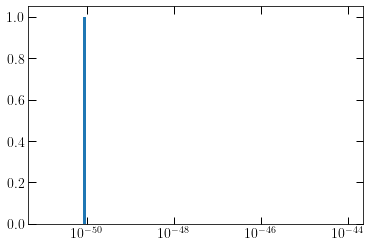

In [9]:
lf_mean = np.mean(lf_chain, axis=0)
lf_mean_err = np.std(lf_chain, axis=0)
# print(lf_mean_err*np.log(10)*(l_bins[1:]-l_bins[:-1])/2)
print(lf_chain.shape)
plt.hist(lf_chain[:, 2, 5], bins=np.logspace(-51, -44, num=100))
ax = plt.gca()
ax.set_xscale('log')
bin_centers = (l_bins[1:]+l_bins[:-1])/2
min(lf_chain[:, 5, -1]), lf_mean[5, -1]*bin_centers[-1]*np.log(10), np.sum(np.isnan(lf_chain))


In [10]:
sorted_lf = np.sort(lf_chain, axis=0)
# probs = np.cumsum(sorted_lf, axis=0)
# probs /= probs[-1]
# probs = np.nan_to_num(probs)
# print(probs)
mid_id = len(sorted_lf) // 2
high_id = (len(sorted_lf) * 84) // 100
low_id = (len(sorted_lf) * 16) // 100
print(low_id, mid_id, high_id, len(sorted_lf))

# print(lf_errs.shape, sorted_lf.shape)
sh = sorted_lf.shape
median_vals = np.zeros((sh[1], sh[2]))
med_errs = np.zeros((sh[1], 2, sh[2]))
# low_errs = np.zeros((sh[1], sh[2]))
for i in range(sh[1]):
    for j in range(sh[2]):
        median_vals[i, j] = sorted_lf[:, i, j][mid_id]
        med_errs[i, 1, j] = sorted_lf[:, i, j][high_id] - median_vals[i, j]
#         med_errs[i, 1, j] = sorted_lf[:, i, j][high_id]
        med_errs[i, 0, j] = median_vals[i, j] - sorted_lf[:, i, j][low_id]
#         med_errs[i, 0, j] = sorted_lf[:, i, j][low_id]

# print(med_errs.shape, np.moveaxis(lf_errs, 1, -1).shape)
# med_errs
# med_errs = np.sqrt(med_errs**2 + np.moveaxis(lf_errs, 1, -1)**2)
# print(lf_errs)

0 0 0 1


In [11]:
z = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in xservs_catalog])
l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index)

poi_lower, poi_upper = vmax.poisson_errors(l, z, l_bins, z_bins)

for i in range(sh[1]):
    for j in range(sh[2]):
        med_errs[i, 1, j] = np.sqrt(med_errs[i, 1, j]**2 + (median_vals[i, j] * poi_upper[i, j])**2)
        med_errs[i, 0, j] = np.sqrt(med_errs[i, 0, j]**2 + (median_vals[i, j] * poi_lower[i, j])**2)

In [12]:
lit_data={}
others_limits = {}
aird_lade_params_central = {'A': 10**-4.53, 
                               'gamma1':0.62, 
                               'gamma2':3.01,
                               'Lstar': 10**44.77,
                               'zc':0.75,
                               'p1':6.36,
                               'p2':-0.24,
                               'd':-0.19
                              }
aird_lade_params_min = {'A': 10**-4.46, 
                               'gamma1':0.6, 
                               'gamma2':2.9,
                               'Lstar': 10**44.71,
                               'zc':0.66,
                               'p1':5.96,
                               'p2':-0.51,
                               'd':-.21
                              }
aird_lade_params_max = {'A': 10**-4.6, 
                               'gamma1':0.64, 
                               'gamma2':3.12,
                               'Lstar':10**44.83,
                               'zc':0.84,
                               'p1':6.76,
                               'p2':0.03,
                               'd':-0.17
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(40, 47.0, num=50)
aird_mid = af.LADE(ls, center_zbins, **aird_lade_params_central, no_k=True)
aird_high = af.LADE(ls, center_zbins, **aird_lade_params_max, no_k=True)
aird_low = af.LADE(ls, center_zbins, **aird_lade_params_min, no_k=True)
aird_limits = [[41, 45.25], [41, 45.25], [41.75, 45.75], [41.75, 45.75], [46, 46], [46, 46], [42.5, 45], [42.5, 45.25], [42.5, 45.25]]
others_limits['Aird LADE'] = 10**np.array(aird_limits)
# print(ranalli_mid[0])
lit_data['Aird LADE'] = list(zip(aird_mid, aird_high, aird_low))
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

In [13]:
importlib.reload(utils)
importlib.reload(vmax)
ranalli_lade_params_central = {'A': 10**-3.53, 
                               'gamma1':0.16, 
                               'gamma2':2.48,
                               'Lstar': 10**42.72,
                               'zc':1.72,
                               'p1':4.67,
                               'p2':-0.3,
                               'd':-0.29
                              }
ranalli_lade_params_min = {'A': 10**-3.65, 
                               'gamma1':0.09, 
                               'gamma2':2.37,
                               'Lstar': 10**42.65,
                               'zc':1.53,
                               'p1':4.35,
                               'p2':-0.91,
                               'd':-0.31
                              }
ranalli_lade_params_max = {'A': 10**-3.48, 
                               'gamma1':0.23, 
                               'gamma2':2.6,
                               'Lstar':10**42.82,
                               'zc':1.93,
                               'p1':5.0,
                               'p2':0.02,
                               'd':-0.26
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(40, 47.0, num=50)
ranalli_mid = af.LADE(ls, center_zbins, **ranalli_lade_params_central)
ranalli_high = af.LADE(ls, center_zbins, **ranalli_lade_params_max)
ranalli_low = af.LADE(ls, center_zbins, **ranalli_lade_params_min)
ranalli_limits = [[42, 45], [42, 46], [42, 46], [42.25, 46], [42.25, 46], [42.5, 45.25], [43.25, 45.25], [43.25, 45.25], [43.25, 45.25]]
others_limits['Ranalli LADE'] = 10**np.array(ranalli_limits)
# print(ranalli_mid[0])
lit_data['Ranalli LADE'] = list(zip(ranalli_mid, ranalli_high, ranalli_low))
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

In [14]:
# # plot_files = ['./output/lf_ir_montecarlo.npz']
# plot_files = ['./output/lf_xray.npz', './output/lf_xray_crossmatch_ir_selected.npz', './output/lf_xray_crossmatch_xray_selected.npz']
# # plot_files = []
# labs = ['Full XSERVS sample', 'Crossmatch, IR selected', 'Crossmatch, X-ray selected']
# otherruns = {}
# for lab, fil in zip(labs, plot_files):
#     with np.load(fil) as infile:
#         lfv = infile['lf_vals']
#         lfe = infile['lf_errs']
#     otherruns[lab] = [lfv, lfe]

In [15]:
import importlib
importlib.reload(vmax)

# otherruns = {}
np.savez('./output/' + outfile + '.npz', lf_vals=median_vals, lf_errs=med_errs, z_bins=z_bins, l_bins=l_bins)

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()

plot_files = ['./output/lf_xray.npz', './output/lf_xray_crossmatch_ir_selected.npz', './output/lf_xray_crossmatch_xray_selected.npz']

labs = ['Full XSERVS sample', 'Crossmatch, IR selected']#, 'Crossmatch, X-ray selected']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]


/Users/runburg/github/agn_lf/source/vmax.py:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


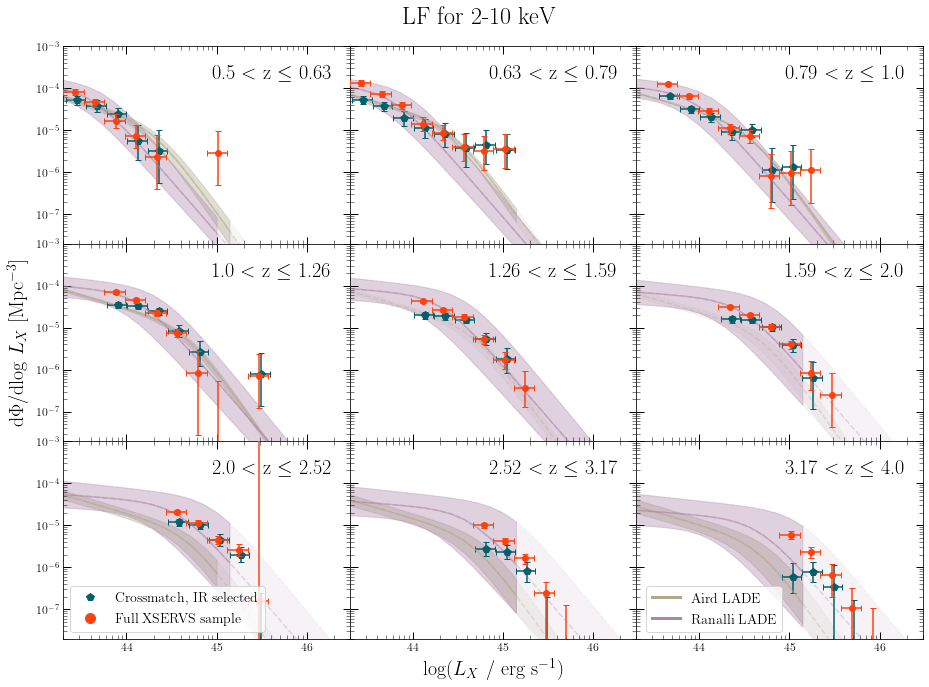

In [16]:
import importlib
importlib.reload(vmax)

main_results = otherruns.pop(labs[0])

outfile = 'lf_xray_xmatch'

fig, axs, big_ax = vmax.plot_lf_vmax(main_results[0], main_results[1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, others_limits=others_limits, lum_limits=l_limits, this_label=labs[0], title='LF for 2-10 keV', outfile='./output/paper_plots/'+outfile+'.pdf', lum_sublabel='_X')

/Users/runburg/github/agn_lf/source/vmax.py:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))


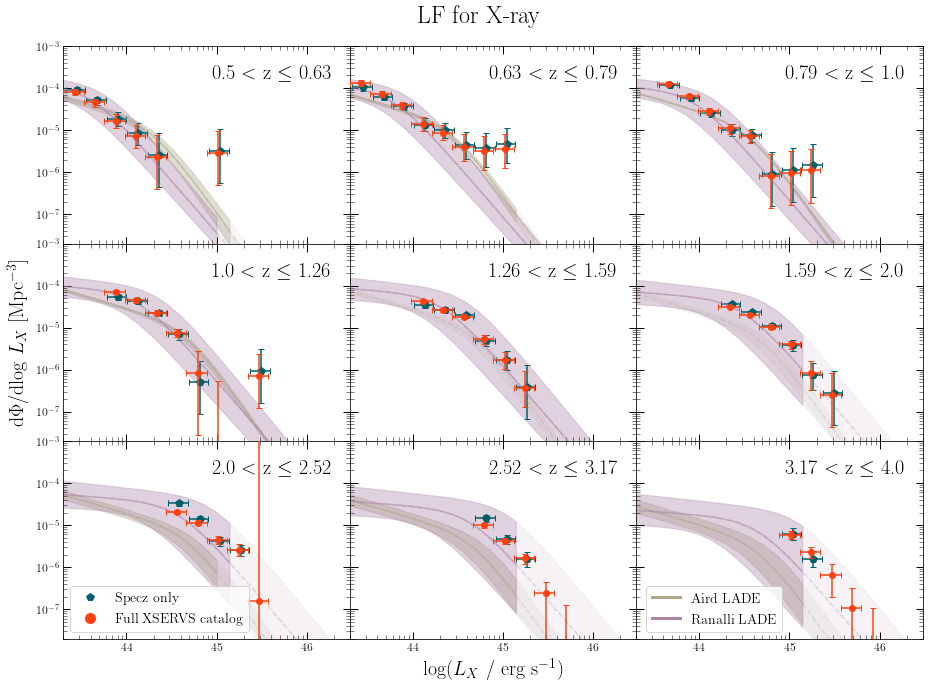

In [17]:
plot_files = ['./output/lf_xray.npz']
labels = ['full XSERVS catalog']
mainruns = {}
for lab, fil in zip(labels, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    mainruns[lab] = [lfv, lfe]
    
plot_files = ['./output/lf_xray_specz_only.npz']
labs = ['Specz only']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]

outfile = 'lf_xray_full_vs_specz'
label = 'Full XSERVS catalog'
fig, axs, big_ax = vmax.plot_lf_vmax(mainruns[labels[0]][0], mainruns[labels[0]][1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, lum_limits=l_limits, title=r'LF for X-ray', others_limits=others_limits, this_label=label, outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{X}')

In [18]:
np.sum((l > l_bins[5]) & (z > z_bins[1]) & (z < z_bins[2])), z_bins[1], z_bins[2], l_bins[5]

(7, 0.6299605249474366, 0.7937005259840997, 2.7248857796902753e+44)

In [19]:
# l = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=20)
# z = np.linspace(z_sample_min, z_sample_max, num=20)
# corrected_cov_func(l, z)


In [20]:
np.sum((z > z_bins[1]) & (z < z_bins[2])), z_bins[1], z_bins[2], l_bins[5]

(206, 0.6299605249474366, 0.7937005259840997, 2.7248857796902753e+44)